# Delta Function

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [2]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Defining the model

We define a new agent type :class:`Person` by creating a subclass of :class:`Agent`.
This agent has two methods: :func:`setup` will be called automatically at the agent's creation,
and :func:`being_sick` will be called by the :func:`Model.step` function.
Three tools are used within this class:

- :attr:`Agent.p` returns the parameters of the model
- :func:`Agent.neighbors` returns a list of the agents' peers in the network
- :func:`random.random` returns a uniform random draw between 0 and 1

wealth by race https://www.federalreserve.gov/econres/notes/feds-notes/disparities-in-wealth-by-race-and-ethnicity-in-the-2019-survey-of-consumer-finances-20200928.html

rank for the US:
https://www.federalreserve.gov/econres/notes/feds-notes/wealth-inequality-and-the-racial-wealth-gap-accessible-20211022.htm#fig3


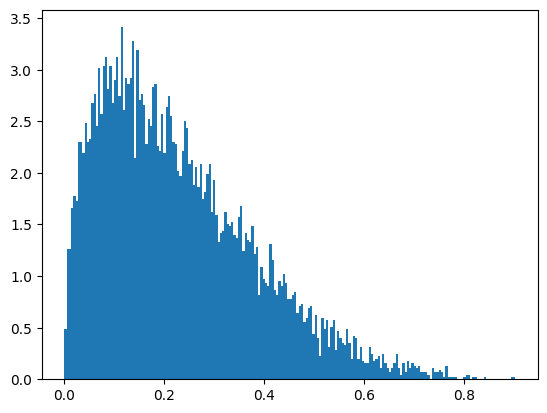

In [3]:
import matplotlib.pyplot as plt

values = plt.hist(np.random.beta(1.5, 5, 10000),

                  bins=200, density=True)

plt.show()

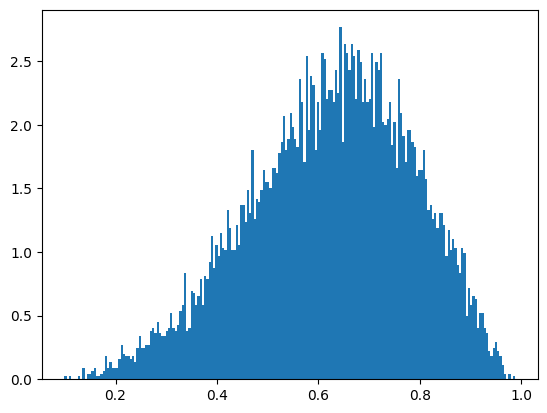

In [4]:
import matplotlib.pyplot as plt

values = plt.hist(np.random.beta(5, 3, 10000),

                  bins=200, density=True)

plt.show()

In [5]:
class Person(ap.Agent):
    
    def setup(self):  
        """ Initialize a new variable at agent creation. """
        # self.condition = 0  # Susceptible = 0, Infected = 1, Recovered = 2
        a = 5 # shape
        rng = np.random.default_rng()
        
        
        # race
        self.race =  rng.binomial(1,0.2)#binary not white0.2 /  white for the moment 0.8
        
        if self.race == 0:
            self.wealth = rng.beta(1.5, 5,1)[0]
        else:
            self.wealth = rng.beta(5, 3,1)[0]
            

        # fraud
        self.fraud = rng.binomial(1,0.5,1)[0]
        self.fraud_pred = -1
        self.convicted = 0

        
    def fraud_algo(self):
        """ DM mechanism can also be ML"""
        rng = np.random.default_rng()
        # self.fraud_pred = rng.binomial(1, 0.5)
        if self.fraud == 1:
            fraud_cor = rng.binomial(1,self.p.acc)
        else:
            fraud_cor = rng.binomial(1,1-self.p.acc)
            
        self.fraud_pred = rng.binomial(1, fraud_cor*(0.8-self.p.wealth_appeal_corr))
        

    def appeal(self):
        """Possibility to Appeal to Fraud Algo Decision"""
        rng = np.random.default_rng()
#         print('bye')
        if self.fraud_pred == 1 and self.wealth > self.p.appeal_wealth:
            self.fraud_algo()
            # self.fraud_pred = rng.binomial(1, 0.4)
            
    def convict(self):
        """ Conviction and Consequences"""
        rng = np.random.default_rng()
        if self.fraud_pred == 1:
            if rng.binomial(1,0.8) == 1:
                # pay fine, get on record, 
                self.wealth = self.wealth - np.max([0.01,(self.wealth*0.05)])
                self.convicted =+ 1
                self.fraud = rng.binomial(1,0.5,1)[0]
                self.fraud_pred = 0
    
    def wealth_grow(self):
        self.wealth = min(1,self.wealth+pow(self.wealth,2)*0.01)
            
            
        


#     def step(self):
#         # The agent's step will go here.
#         # For demonstration purposes we will print the agent's unique_id
#         self.appeal()
#         print("Hi, I am agent " + str(self.unique_id) + ".")
#         # print("my wealth, job, fraud, fraud_pred is:" + str(self.wealth)+ str(self.job) + str(self.fraud)+ str(self.fraud_pred))

Next, we define our model :class:`VirusModel` by creating a subclass of :class:`Model`.
The four methods of this class will be called automatically at different steps of the simulation,
as described in :ref:`overview_simulation`.

In [6]:
class VirusModel_baseline(ap.Model):
    
    def setup(self): #before
        """ Initialize the agents and network of the model. """
        
        # Create agents and network
        self.agents = ap.AgentList(self, self.p.agents, Person)
    
        self.w_wealth_t0 = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        self.nw_wealth_t0 = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
    

    def step(self): # during each step
        """ Define the models' events per simulation step. """
        self.agents.fraud_algo()
#         self.agents.appeal()
        self.agents.convict()
        self.agents.wealth_grow()
        


    def update(self):  # after each step
        """ Record variables after setup and each step. """
        self.agents.record('wealth')
        self.agents.record('fraud_pred')
        self.agents.record('fraud')
        self.agents.record('race')
        
        
    
    def end(self):     
        """ Record evaluation measures at the end of the simulation. """
#         self.report('wealth', self.agents.wealth)
#         self.report('race', self.agents.race)
#         self.report('my_measure', 1)
        
        # record race wealth ratio 
        
        w_wealth_tn = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        nw_wealth_tn = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
        
        w_wr_ratio = w_wealth_tn/self.w_wealth_t0
        nw_wr_ratio = nw_wealth_tn/self.nw_wealth_t0
        
        self.report('w_wr_ratio', w_wr_ratio)
        self.report('nw_wr_ratio', nw_wr_ratio)
            
        
        
#         # Record final evaluation measures
#         self.report('Total share infected', self.I + self.R) 
#         self.report('Peak share infected', max(self.log['I']))

In [7]:
class VirusModel(ap.Model):
    
    def setup(self): #before
        """ Initialize the agents and network of the model. """
        
        # Create agents and network
        self.agents = ap.AgentList(self, self.p.agents, Person)
    
        self.w_wealth_t0 = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        self.nw_wealth_t0 = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
    

    def step(self): # during each step
        """ Define the models' events per simulation step. """
        self.agents.fraud_algo()
        self.agents.appeal()
        self.agents.convict()
        self.agents.wealth_grow()
        


    def update(self):  # after each step
        """ Record variables after setup and each step. """
        self.agents.record('wealth')
        self.agents.record('fraud_pred')
        self.agents.record('fraud')
        self.agents.record('race')
        
        
    
    def end(self):     
        """ Record evaluation measures at the end of the simulation. """
#         self.report('wealth', self.agents.wealth)
#         self.report('race', self.agents.race)
#         self.report('my_measure', 1)
        
        # record race wealth ratio 
        
        w_wealth_tn = sum((self.agents.select(self.agents.race == 1)).wealth) / len((self.agents.select(self.agents.race == 1)))
        nw_wealth_tn = sum((self.agents.select(self.agents.race == 0)).wealth) / len((self.agents.select(self.agents.race == 0)))
        
        w_wr_ratio = w_wealth_tn/self.w_wealth_t0
        nw_wr_ratio = nw_wealth_tn/self.nw_wealth_t0
        
        self.report('w_wr_ratio', w_wr_ratio)
        self.report('nw_wr_ratio', nw_wr_ratio)
            
        
        
#         # Record final evaluation measures
#         self.report('Total share infected', self.I + self.R) 
#         self.report('Peak share infected', max(self.log['I']))

## Vizualisation

In [8]:
def viz(data, x, y, hue):
    fig, ax = plt.subplots()

    sns.lineplot(ax = ax,
                 data = data,
                 x = x,
                 y = y,
                 hue = hue,
                 marker = 'o')

    plt.show()

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

Completed: 100 steps
Run time: 0:00:03.323076
Simulation finished


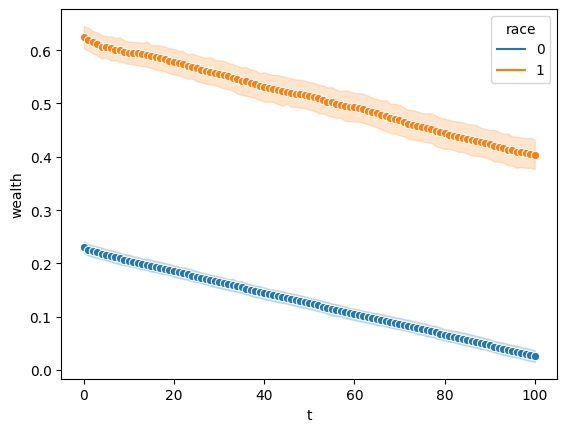

In [9]:
parameters = {
    'my_parameter':42,
    'agents':1000,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': 0.2 # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    
}

model_baseline = VirusModel_baseline(parameters)
results_baseline = model_baseline.run() 

df_baseline = results_baseline['variables']['Person']

viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'].astype(float), df_baseline['race'])

Completed: 100 steps
Run time: 0:00:04.705455
Simulation finished


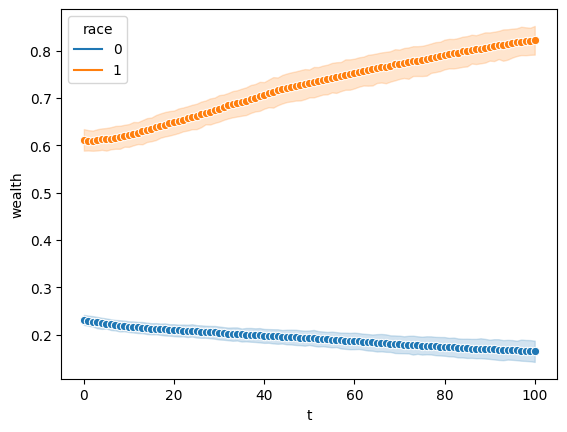

In [10]:
parameters = {
    'my_parameter':42,
    'agents':1000,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': 0.2 # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    
}

model = VirusModel(parameters)
results = model.run() 

df = results['variables']['Person']

viz(df, df.index.get_level_values('t'), df['wealth'].astype(float), df['race'])

In [11]:
# create baseline value
df_b1 = df_baseline.iloc[(df_baseline['race'] == 1).values] 
baseline1 = df_b1.groupby(level='t').mean()
# df_b
df_b0 = df_baseline.iloc[(df_baseline['race'] == 0).values] 
baseline0 = df_b0.groupby(level='t').mean()

In [12]:
df_x1 = df.iloc[(df['race'] == 1).values] 
df_wb1 = df_x1['wealth'] - baseline1['wealth']
df_x1['wealth'] = df_wb1




df_x0 = df.iloc[(df['race'] == 0).values] 
df_wb0 = df_x0['wealth'] - baseline0['wealth']
df_x0['wealth'] = df_wb0

df_xb = pd.concat([df_x0, df_x1])


/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_74391/2096043862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x1['wealth'] = df_wb1
/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_74391/2096043862.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x0['wealth'] = df_wb0


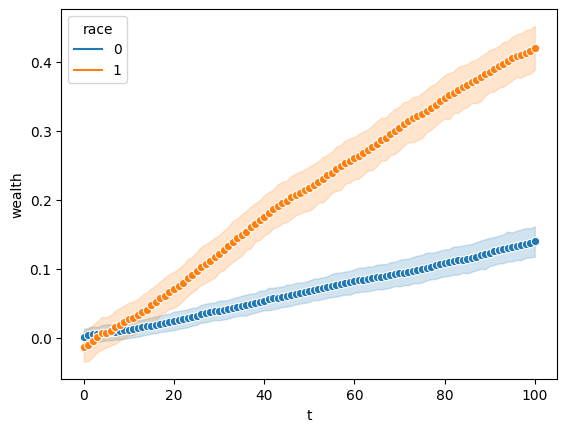

In [13]:
viz(df_xb, df_xb.index.get_level_values('t'), df_xb['wealth'].astype(float), df_xb['race'])

## Delta Function 

In [14]:
# run baseline and normal model and save results
model_baseline = VirusModel_baseline(parameters)
results_baseline = model_baseline.run() 

df_baseline = results_baseline['variables']['Person']

model = VirusModel(parameters)
results = model.run() 

df = results['variables']['Person']

Completed: 100 steps
Run time: 0:00:03.311142
Simulation finished
Completed: 100 steps
Run time: 0:00:04.537451
Simulation finished


In [15]:
# create baseline value
def delta_function(disc_axis, df, df_baseline):
    df_b1 = df_baseline.iloc[(df_baseline[disc_axis] == 1).values] 
    df_wb1 = df.iloc[(df[disc_axis] == 1).values] ['wealth'] - df_b1.groupby(level='t').mean()['wealth']
    df_x1['wealth'] = df_wb1
    
    df_b0 = df_baseline.iloc[(df_baseline[disc_axis] == 0).values] 
    df_wb0 = df.iloc[(df[disc_axis] == 0).values] ['wealth'] - df_b0.groupby(level='t').mean()['wealth']
    df_x0['wealth'] = df_wb0

    df_xb = pd.concat([df_x0, df_x1])
    
    return df_xb

/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_74391/642462805.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x1['wealth'] = df_wb1
/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_74391/642462805.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x0['wealth'] = df_wb0


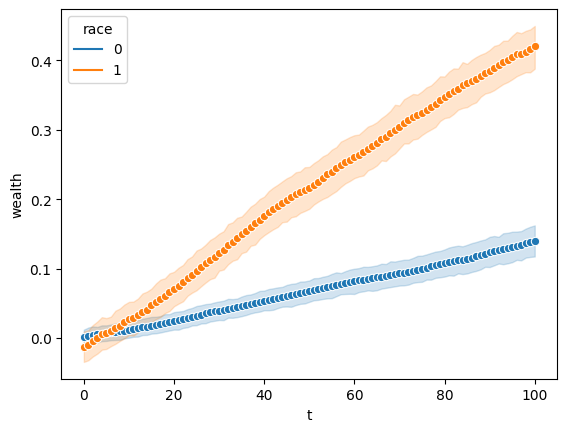

In [16]:
delta_function('race',df, df_baseline)
viz(df_xb, df_xb.index.get_level_values('t'), df_xb['wealth'].astype(float), df_xb['race'])

Do I want this or do I want just one line that indicates if r0 or r1 profits more? This
